In [ ]:
#Create G-K templates from GAIA data cross-matched with 2Masss

In [1]:
%matplotlib inline
import numpy as np
import numpy.ma as ma
import matplotlib.pyplot as plt
import math
import pandas as pd

# Functions

In [2]:
def cleanData(t,QFlags,Jmag,Kmag,Hmag,dup,Source,s1):
    #Masks data values 
    
    # mask all data that does not have a Qfl value of A
    for i in range(0,len(QFlags)):
        if(QFlags[i][0] == ord("A")):
            Jmag.mask[i] = False
        else:
             Jmag.mask[i] = True
            
    for i in range(0,len(QFlags)):
        if(QFlags[i][2] == ord("A")):
            Kmag.mask[i] = False
        else:
            Kmag.mask[i] = True  
        
    for i in range(0,len(QFlags)):
        if(QFlags[i][1] == ord("A")):
            Hmag.mask[i] = False
        else:
            Hmag.mask[i] = True
    
    #mask all values with dup = 1
    imask = 0
    for i in range(0,len(dup)):
        if (dup[i] > 0.5):
            imask = imask + 1
            row = t[i]
            idx = row._index
            cols = row._table.columns.values()
            for col in cols:
                col.mask[i] = True
    for i in range(0,len(dup)):
        if(dup[i] > 0.5):
            print(i,dup[i])
    print("Masked ",imask," rows in which dup is equal to 1")
    
    #remove dupliacte matches
    Test = Source.compressed()
    unique = set()
    Gdups = set()

    for i in range(0,len(Test)):
        if(Test[i] in unique):
            print("GAIA Duplicate Source: ",Test[i])
            Gdups.add(Test[i])
        else:
            unique.add(Test[i])
            last = Test[i]
    print("Finished GAIA Duplicate Check. Found: ", len(Gdups))

    for i in range(0,len(Source)):
        if(Source.mask[i] == False):
            Name = Source[i]
            if(Name in Gdups):
                row = t[i]
                idx = row._index
                cols = row._table.columns.values()
                for col in cols:
                    col.mask[i] = True
    print("Finished masking all GAIA duplicates. All sources involved")
    TwoM = t["_2MASS"]
    unique = set()
    Tdups = set()
    Test = TwoM.compressed()
    for i in range(0,len(Test)):
        if(Test[i] in unique):
            print("2MASS Duplicate Source: ",Test[i])
            Tdups.add(Test[i])
        else:
            unique.add(Test[i])
            last = Test[i]
    print("Finished 2MASS Duplicate Check. Found: ", len(Tdups))

    for i in range(0,len(Source)):
        if(Source.mask[i] == False):
            Name = Source[i]
            if(Name in Tdups):
                print(Source[i],s1[i],Gmag[i],Vmag[i]-Gmag[i],Jmag[i],Kmag[i],TwoM[i])
                
    #masked rows with J-G greater than 5 sigma from mean
    J_G = Jmag-Gmag
    JGmean = np.mean(J_G)
    JGstd = np.std(J_G)
    imask = 0
    for i in range(0,len(J_G)):
        if(abs(J_G[i] - JGmean) > 5*JGstd):
            imask = imask + 1
            row = t[i]
            idx = row._index
            cols = row._table.columns.values()
            for col in cols:
                col.mask[i] = True
    print("Masked ",imask," rows based on J-G color > 5 sigma from mean")
    
    return t

In [3]:
def AbsoluteMagnitudes(plx,Vmag,Bmag,Gmag,Jmag,Hmag,Kmag):
    #Calculate distance, and absolute magnitudes
    
    Dist = ma.array([])
    Vmags = ma.array([])
    Bmags = ma.array([])
    Gmags = ma.array([])
    Jmags = ma.array([])
    Hmags = ma.array([])
    Kmags = ma.array([])

    Dist = 1000./plx
    Vmags = Vmag - 5 * np.log10(Dist) + 5
    Bmags = Bmag - 5 * np.log10(Dist) + 5
    Gmags = Gmag - 5 * np.log10(Dist) + 5
    Jmags = Jmag -5 * np.log10(Dist) + 5
    Hmags = Hmag - 5 * np.log10(Dist) + 5
    Kmags = Kmag - 5 * np.log10(Dist) + 5
    
    return Dist,Vmags,Bmags,Gmags,Jmags,Hmags,Kmags

In [5]:
def ColorClassification(Gmags,Kmags,colors):    
    #split the stars into different categories based on G-K
    
    G_K = Gmags-Kmags
    color = np.ones(len(G_K))*1000
    for i in range(len(colors)):
        for j in range(len(G_K)):
            if (i == 0):
                if (G_K[j] <= colors[i]):
                    color[j] = colors[i]
            elif(G_K[j] <= colors[i] and G_K[j] > colors[i-1]):
                color[j] = colors[i]
    return color

In [35]:
def CreateTemplates(color,colors,wvl,wvl2,Vmags,Bmags,Gmags,Jmags,Hmags,Kmags):
    #for each color class, a template is created of the absolute magnitudes of the stars and their color indices
    
    G_K = Gmags-Kmags
    avg_colors = np.array([])
    err_colors = np.array([])
    stars = np.array([])
    for c in colors:
        #create array of values for color indices and absolute magnitudes
        G_B_array = ma.array([])
        G_V_array = ma.array([])
        G_J_array = ma.array([])
        G_H_array = ma.array([])
        G_K_array = ma.array([])
        B = ma.array([])
        V = ma.array([])
        G = ma.array([])
        J = ma.array([])
        H = ma.array([])
        K = ma.array([])
        star_count = 0
        #fill arrays with values if the values are part of the color category
        for i in range(len(G_K)):
            if (color[i] == c):
                G_B_array = np.append(G_B_array,Gmags[i]-Bmags[i])
                G_V_array = np.append(G_V_array,Gmags[i]-Vmags[i])
                G_J_array = np.append(G_J_array,Gmags[i]-Jmags[i])
                G_H_array = np.append(G_H_array,Gmags[i]-Hmags[i])
                G_K_array = np.append(G_K_array,Gmags[i]-Kmags[i])
                B = np.append(B,Bmags[i])
                V = np.append(V,Vmags[i])
                G = np.append(G,Gmags[i])
                J = np.append(J,Jmags[i])
                H = np.append(H,Hmags[i])
                K = np.append(K,Kmags[i])
                star_count = star_count +1
        #average G-K value
        avg_colors = np.append(avg_colors,np.mean(G_K_array))
        err_colors = np.append(err_colors,np.std(G_K_array))
        #number of stars per color
        stars = np.append(stars,star_count)
        #relative SED
        mag_array = [np.mean(G_B_array), np.mean(G_V_array),\
                     np.mean(G_J_array), np.mean(G_H_array), np.mean(G_K_array)]
        std_array = [np.std(G_B_array), np.std(G_V_array), \
                     np.std(G_J_array), np.std(G_H_array), np.std(G_K_array)]
        #absolute SED
        mag_array2 = [np.mean(B), np.mean(V), np.mean(G), \
                      np.mean(J), np.mean(H), np.mean(K)]
        std_array2 = [np.std(B), np.std(V), np.std(G), \
                      np.std(J), np.std(H), np.std(K)]
        #add standard deviation error
        
        val = np.sqrt(len(G_B_array))
        std_array3 = std_array/val
        val2 = np.sqrt(len(B))
        std_array4 = std_array2/val2
        
        #stack SEDs
        if (c == colors[0]):
            color_mags = np.array(mag_array)
            color_std = np.array(std_array)
            color_std_err = np.array(std_array3)
            abs_color_mags = np.array(mag_array2)
            abs_color_std = np.array(std_array2)
            abs_color_std_err = np.array(std_array4)
        else:
            color_mags = np.vstack((color_mags,mag_array))
            color_std = np.vstack((color_std,std_array))
            color_std_err = np.vstack((color_std_err,std_array3))
            abs_color_mags = np.vstack((abs_color_mags, mag_array2))
            abs_color_std = np.vstack((abs_color_mags, std_array2))
            abs_color_std_err = np.vstack((abs_color_std_err,std_array4))
    return stars,color_mags,color_std,color_std_err,abs_color_mags,abs_color_std,abs_color_std_err

In [24]:
def CreatePlots(colors,wvl,wvl2,abs_colors_mags,abs_color_std,color_mags,color_std):
    #create SED and Relative SED plots
    
    #plot average absolute magnitude in each filter for each color 
    ax = plt.subplot(111)
    for i in range(len(colors)):
        ax.errorbar(wvl2, abs_color_mags[i,:], yerr = abs_color_std[i,:], linestyle = '-', marker = 'o',label = str(colors[i]))
    ax.set_xlabel('Effective Wavelength (nm)')
    ax.set_ylabel('Average Absolute Magnitude')
    ax.set_title('Spectral Energy Distribution')
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.show()
    
    #plot average color index in each filter for each color 
    ax2 = plt.subplot(111)
    for i in range(len(colors)):
        ax2.errorbar(wvl, color_mags[i,:], yerr = color_std[i,:], linestyle = '-', marker = 'o',label = str(colors[i]))
    ax2.set_xlabel('Effective Wavelength (nm)')
    ax2.set_ylabel('Average Color Index')
    ax2.set_title('Spectral Energy Distribution')
    box2 = ax.get_position()
    ax2.set_position([box.x0, box.y0, box.width * 0.8, box.height])
    ax2.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.show()
    
    return

In [26]:
def PrintToFile(colors,stars,color_mags,color_std,color_std,err,name):
    
    rows = len(colors)
    colors2 = np.zeros([rows,1])
    stars2 = np.zeros([rows,1])
    for i in range(rows):
        colors2[i,0] = colors[i]
        stars2[i,0] = stars[i]
    
    arrays=[stars2,color_mags,color_std,color_std_err]

    # Create an array to return to
    FinalTemplate = colors2

    for array in arrays:
        FinalTemplate = np.concatenate([FinalTemplate, array],axis = 1)
        
    columns = 'color,number_of_stars,G_B,G_V,G_J,G_H,G_K,G_B_std,G_V_std,G_J_std,G_H_std,G_K_std,' + \
            'G_B_std_err,G_V_std_err,G_J_std_err,G_H_std_err,G_K_std_err'
        
    np.savetxt(name, FinalTemplate, delimiter=",",header = columns)
    
    return FinalTemplate

# Read in Data and Create Templates

In [9]:
from astropy.table import Table
t = Table.read('../dr1_200pc_2Mass.vot', format='votable')

print("The astropy reader loads the data into the following variable names:")
print(t.colnames)
print("\nThe number of stars is " + str(len(t)))

#Rename columns
Source = t["Source"]
Gmag = t["__Gmag_"]
#Using Gmag in place of Vmag and Bmag to calculate Vmags and Bmags
Vmag = t["__Gmag_"]
Bmag = t["__Gmag_"]
Jmag = t["Jmag"]
Hmag = t["Hmag"]
Kmag = t["Kmag"]
QFlags = t["Qfl"]
s1= t["d_arcsec"]
plx = t['Plx']
dup = t['Dup'] 

wvl = [420, 477, 1235, 1662, 2159]
wvl2 = [420, 477, 673,1235, 1662, 2159]

#I get [IndexError: too many indices for array] if I do not reinput the table t? 

t = cleanData(t,QFlags,Jmag,Kmag,Hmag,dup,Source,s1)
Dist,Vmags,Bmags,Gmags,Jmags,Hmags,Kmags = AbsoluteMagnitudes(plx,Vmag,Bmag,Gmag,Jmag,Hmag,Kmag)

The astropy reader loads the data into the following variable names:
['d_arcsec', 'RA_ICRS', 'e_RA_ICRS', 'DE_ICRS', 'e_DE_ICRS', 'Source', 'Plx', 'pmRA', 'pmDE', 'RADEcor', 'Dup', '__FG_', 'e__FG_', '__Gmag_', 'Var', '_2MASS', 'RAJ2000', 'DEJ2000', 'errHalfMaj', 'errHalfMin', 'errPosAng', 'Jmag', 'Hmag', 'Kmag', 'e_Jmag', 'e_Hmag', 'e_Kmag', 'Qfl', 'Rfl', 'X', 'MeasureJD']

The number of stars is 191206
Masked  72230  rows in which dup is equal to 1
GAIA Duplicate Source:  5555073729568686592
GAIA Duplicate Source:  5859121851795522560
GAIA Duplicate Source:  101700874199870208
GAIA Duplicate Source:  5621620502608043264
GAIA Duplicate Source:  4340260028239519232
GAIA Duplicate Source:  6038042561484950016
GAIA Duplicate Source:  1147294066657043456
GAIA Duplicate Source:  4328234841366192000
GAIA Duplicate Source:  3262302333060747392
GAIA Duplicate Source:  3416890094513036800
GAIA Duplicate Source:  2984035009725892352
GAIA Duplicate Source:  3324242049302232832
GAIA Duplicate Sou

GAIA Duplicate Source:  2034189420118197120
GAIA Duplicate Source:  4805866953078834048
Finished GAIA Duplicate Check. Found:  457
Finished masking all GAIA duplicates. All sources involved
2MASS Duplicate Source:  b'06513367-4745000'
2MASS Duplicate Source:  b'07390663-4538576'
2MASS Duplicate Source:  b'21045848-1105139'
2MASS Duplicate Source:  b'18394121+0826384'
2MASS Duplicate Source:  b'02472995-0600508'
2MASS Duplicate Source:  b'21453071+2156249'
2MASS Duplicate Source:  b'13301834-4821531'
2MASS Duplicate Source:  b'06543186-0441583'
2MASS Duplicate Source:  b'03301382+7717357'
2MASS Duplicate Source:  b'13025615-3433226'
2MASS Duplicate Source:  b'15290917-3248329'
2MASS Duplicate Source:  b'17430747-8325108'
2MASS Duplicate Source:  b'21280133+4304426'
2MASS Duplicate Source:  b'01355504+3303195'
2MASS Duplicate Source:  b'05351451+3357454'
2MASS Duplicate Source:  b'10121865+1620542'
2MASS Duplicate Source:  b'08135422-5222547'
2MASS Duplicate Source:  b'20224375+1320260'


/astromake/opt/python/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in log10
  del sys.path[0]
/astromake/opt/python/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in log10
  
/astromake/opt/python/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: divide by zero encountered in log10
  from ipykernel import kernelapp as app
/astromake/opt/python/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:16: RuntimeWarning: divide by zero encountered in log10
  app.launch_new_instance()
/astromake/opt/python/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: divide by zero encountered in log10
/astromake/opt/python/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:18: RuntimeWarning: divide by zero encountered in log10


In [ ]:
#Templates

#Template.csv colors = [0.5,1,1.5,2,2.5,3]   
#Template2.csv colors = np.arange(0.1,3,0.1)
#Template3.csv colors = np.arange(-0.5,4,0.25)
#Template4.csv colors = np.arange(-0.5,4,0.5)
#Template5.csv colors = np.arrange(0.25,3,0.25)
#Template6.csv colors = np.arrange(0.2,3,0.2)
#Template7.csv colors = np.arange(0.15,4,0.15)


In [27]:
#classify stars according to color and creates templates
colors = np.arange(0.15,4,0.15)
name ="Template7.csv"

color = ColorClassification(Gmags,Kmags,colors)
stars,color_mags,color_std,color_std_err,abs_color_mags,abs_color_std,abs_color_std_err = \
CreateTemplates(color,colors,wvl,wvl2,Vmags,Bmags,Gmags,Jmags,Hmags,Kmags)

/astromake/opt/python/anaconda3/lib/python3.6/site-packages/numpy/ma/core.py:5060: RuntimeWarning: Mean of empty slice.
  dtype=dtype, **kwargs)[()]
/astromake/opt/python/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:73: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
/astromake/opt/python/anaconda3/lib/python3.6/site-packages/numpy/ma/core.py:5138: RuntimeWarning: Degrees of freedom <= 0 for slice
  ddof=ddof, **kwargs)[()]
/astromake/opt/python/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:105: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/astromake/opt/python/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:125: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
/astromake/opt/python/anaconda3/lib/python3.6/site-packages/numpy/core/numeric.py:58

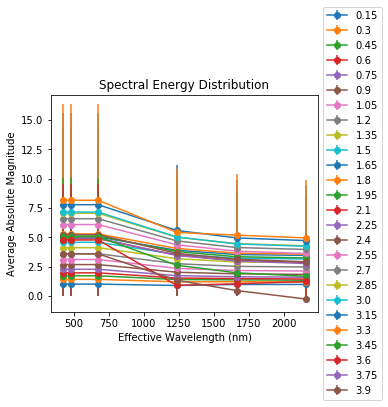

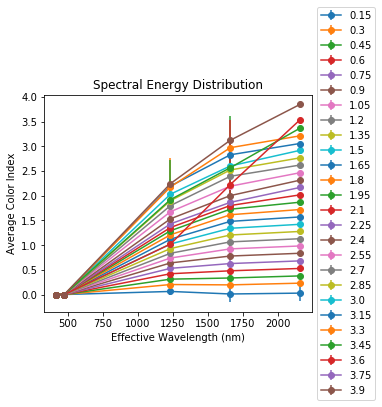

[ 0.15  0.3   0.45  0.6   0.75  0.9   1.05  1.2   1.35  1.5   1.65  1.8
  1.95  2.1   2.25  2.4   2.55  2.7   2.85  3.    3.15  3.3   3.45  3.6
  3.75  3.9 ]
[ 0.06636118  0.31016344  0.50638975  0.70963741  0.91867421  1.11167886
  1.30289009  1.49333146  1.69304956  1.89007668  2.08727653  2.28336745
  2.48389321  2.68394602]
[ 0.15217309  0.05676153  0.0569913   0.05707592  0.05590432  0.05584504
  0.05725734  0.05731323  0.05731147  0.05735224  0.05676159  0.05578067
  0.05617404  0.05568193]
[[ 0.          0.          0.0622226   0.01072497  0.02804929]
 [ 0.          0.          0.20222312  0.19509544  0.22983737]
 [ 0.          0.          0.31103213  0.33456749  0.37665655]
 [ 0.          0.          0.42083522  0.48018934  0.52754909]
 [ 0.          0.          0.53014445  0.62681273  0.6808368 ]
 [ 0.          0.          0.63964409  0.77923709  0.83521824]
 [ 0.          0.          0.73910305  0.92406056  0.98323162]
 [ 0.          0.          0.83491224  1.06597497  1.1299

In [29]:
#Create plots and save values to a file
CreatePlots(colors,wvl,wvl2,abs_color_mags,abs_color_std,color_mags,color_std)

print(colors)
print(avg_colors)
print(err_colors)
print(color_mags)
print(color_std)

finaltemplate = PrintToFile(colors,stars,color_mags,color_std,color_std_err,name)
print(finaltemplate)

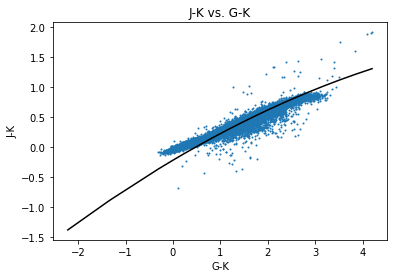

/astromake/opt/python/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:18: RankWarning: Polyfit may be poorly conditioned
/astromake/opt/python/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:19: RankWarning: Polyfit may be poorly conditioned


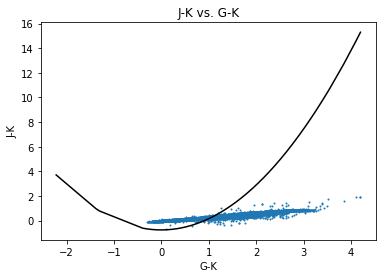

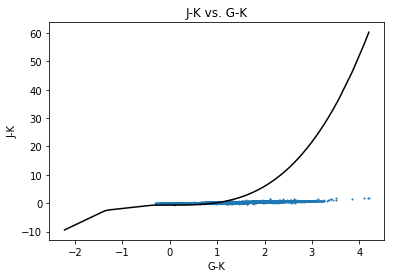

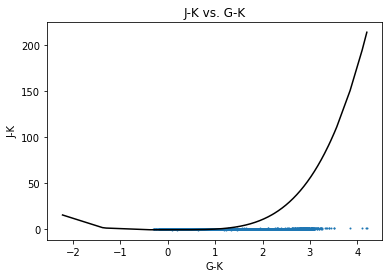

In [13]:
#Plot of J-K against G-K with fittings

G_K2 = Gmags - Kmags
J_K2 = Jmags - Kmags
x = G_K2
y  = J_K2
plt.scatter(x,y,s=1)
x2 = np.sort(x)
y2 = -0.215+0.468*x2-0.025*np.power(x2,2)
plt.plot(x2,y2,c='k')
plt.xlabel('G-K')
plt.ylabel('J-K')
plt.title('J-K vs. G-K')
plt.show()

#polyfit
[a,b,c] = np.polyfit(x,y,2)
[a2,b2,c2,d2] = np.polyfit(x,y,3)
[a3,b3,c3,d3,e3] = np.polyfit(x,y,4)

plt.scatter(x,y,s=1)
x2 = np.sort(x)
y2 = a*x2+b*np.power(x2,2) + c
plt.plot(x2,y2,c='k')
plt.xlabel('G-K')
plt.ylabel('J-K')
plt.title('J-K vs. G-K')
plt.show()

plt.scatter(x,y,s=1)
x2 = np.sort(x)
y2 = a2*x2+b2*np.power(x2,2)+c2*np.power(x2,3) + d2
plt.plot(x2,y2,c='k')
plt.xlabel('G-K')
plt.ylabel('J-K')
plt.title('J-K vs. G-K')
plt.show()

plt.scatter(x,y,s=1)
x2 = np.sort(x)
y2 = a3*x2+b3*np.power(x2,2)+c3*np.power(x2,3) + d3*np.power(x2,4) +e3
plt.plot(x2,y2,c='k')
plt.xlabel('G-K')
plt.ylabel('J-K')
plt.title('J-K vs. G-K')
plt.show()

#polyeval

(array([  1.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          2.00000000e+00,   2.00000000e+00,   4.00000000e+00,
          5.00000000e+00,   9.00000000e+00,   1.60000000e+01,
          1.80000000e+01,   1.80000000e+01,   3.70000000e+01,
          5.70000000e+01,   1.43000000e+02,   4.29000000e+02,
          7.97000000e+02,   1.26000000e+03,   1.61800000e+03,
          2.07400000e+03,   3.52900000e+03,   8.07700000e+03,
          1.55280000e+04,   2.03460000e+04,   2.01510000e+04,
          1.49260000e+04,   1.08180000e+04,   7.48400000e+03,
          4.47200000e+03,   2.44300000e+03,   1.15900000e+03,
          5.94000000e+02,   3.53000000e+02,   1.79000000e+02,
          1.20000000e+02,   5.50000000e+01,   3.40000000e+01,
          3.80000000e+01,   4.70000000e+01,   4.20000000e+01,
          5.50000000e+01,   6.40000000e+01,   7.40000000e+01,
          6.70000000e+01,   7.40000000e+01,   7.40000000e+01,
          8.70000000e+01,   7.30000000e+01,   8.90000000e+01,
        

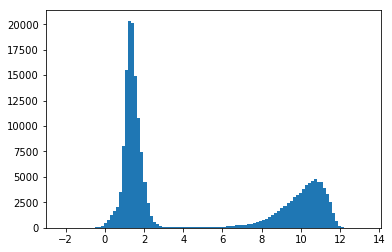

In [33]:
G_K3 = Gmags-Kmags
plt.hist(G_K3,100)

In [17]:
#read in templates
from numpy import genfromtxt

#Template1
my_data = genfromtxt('Template.csv', delimiter=',')
print(my_data)
print(len(my_data))

#find how many errorbars are greater than the intervals
count = 0
for i in range(len(my_data)):
    if my_data[i,2] >= 0.5:
        count = count+1
print(count)


[[ 0.5         0.2778096   0.17433203  0.          0.          0.23989565
   0.24253559  0.2778096   0.          0.          0.12416791  0.16938361
   0.17433203]
 [ 1.          0.83354451  0.13610322  0.          0.          0.63657092
   0.77753901  0.83354451  0.          0.          0.11174483  0.14607786
   0.13610322]
 [ 1.5         1.27265005  0.1349335   0.          0.          0.92735191
   1.20062827  1.27265005  0.          0.          0.10556694  0.14577656
   0.1349335 ]
 [ 2.          1.7050845   0.13856932  0.          0.          1.1977241
   1.59370879  1.7050845   0.          0.          0.15065002  0.20839007
   0.13856932]
 [ 2.5         2.16733439  0.12832688  0.          0.          1.44233301
   1.89368908  2.16733439  0.          0.          0.32954202  0.53487965
   0.12832688]
 [ 3.          2.67427228  0.12657941  0.          0.          1.83875903
   2.4126506   2.67427228  0.          0.          0.29938619  0.48909329
   0.12657941]]
6
0


In [18]:
#Template2
my_data = genfromtxt('Template2.csv', delimiter=',')
print(my_data)
print(len(my_data))

#find how many errorbars are greater than the intervals
count = 0
for i in range(len(my_data)):
    if my_data[i,2] >= 0.1:
        count = count+1
print(count)

[[ 0.1        -0.01466285  0.17568069  0.          0.          0.03317203
  -0.02813761 -0.01466285  0.          0.          0.07570449  0.18467759
   0.17568069]
 [ 0.2         0.15169084  0.02907131  0.          0.          0.14768119
   0.1227802   0.15169084  0.          0.          0.0365206   0.04145054
   0.02907131]
 [ 0.3         0.25283938  0.02838653  0.          0.          0.2179522
   0.21669982  0.25283938  0.          0.          0.04311219  0.03995418
   0.02838653]
 [ 0.4         0.35186091  0.02916121  0.          0.          0.2911196
   0.30881224  0.35186091  0.          0.          0.04280327  0.04460851
   0.02916121]
 [ 0.5         0.45180921  0.02919394  0.          0.          0.36826808
   0.40893391  0.45180921  0.          0.          0.04698757  0.044529
   0.02919394]
 [ 0.6         0.55042757  0.02894888  0.          0.          0.43677971
   0.50210564  0.55042757  0.          0.          0.05734803  0.05122477
   0.02894888]
 [ 0.7         0.65320571 

In [19]:
#Template3
my_data = genfromtxt('Template3.csv', delimiter=',')
print(my_data)
print(len(my_data))

#find how many errorbars are greater than the intervals
count = 0
for i in range(len(my_data)):
    if my_data[i,2] >= 0.25:
        count = count+1
print(count)

[[-0.5        -1.56025052  0.38243138  0.          0.          0.
  -1.4297502  -1.56025052  0.          0.          0.          0.85741613
   0.38243138]
 [-0.25       -0.30066665  0.04577957  0.          0.         -0.15222226
  -0.28877783 -0.30066665  0.          0.          0.08467951  0.15229121
   0.04577957]
 [ 0.         -0.06990908  0.06093063  0.          0.         -0.02033938
  -0.07795757 -0.06990908  0.          0.          0.05062499  0.06082518
   0.06093063]
 [ 0.25        0.14386952  0.06885327  0.          0.          0.14015681
   0.11632566  0.14386952  0.          0.          0.06303358  0.07617239
   0.06885327]
 [ 0.5         0.38428713  0.07111702  0.          0.          0.31660809
   0.34201219  0.38428713  0.          0.          0.06672141  0.07782362
   0.07111702]
 [ 0.75        0.63862684  0.0724836   0.          0.          0.4999248
   0.5864484   0.63862684  0.          0.          0.07575589  0.08600825
   0.0724836 ]
 [ 1.          0.90350619  0.06

In [20]:
#Template4
my_data = genfromtxt('Template4.csv', delimiter=',')
print(my_data)
print(len(my_data))

#find how many errorbars are greater than the intervals
count = 0
for i in range(len(my_data)):
    if my_data[i,2] >= 0.5:
        count = count+1
print(count)

[[-0.5        -1.56025052  0.38243138  0.          0.          0.
  -1.4297502  -1.56025052  0.          0.          0.          0.85741613
   0.38243138]
 [ 0.         -0.08184481  0.0789982   0.          0.         -0.02716091
  -0.08886206 -0.08184481  0.          0.          0.06045106  0.0829936
   0.0789982 ]
 [ 0.5         0.3035578   0.1335768   0.          0.          0.25735788
   0.26622938  0.3035578   0.          0.          0.10599648  0.13164823
   0.1335768 ]
 [ 1.          0.83354451  0.13610322  0.          0.          0.63657092
   0.77753901  0.83354451  0.          0.          0.11174483  0.14607786
   0.13610322]
 [ 1.5         1.27265005  0.1349335   0.          0.          0.92735191
   1.20062827  1.27265005  0.          0.          0.10556694  0.14577656
   0.1349335 ]
 [ 2.          1.7050845   0.13856932  0.          0.          1.1977241
   1.59370879  1.7050845   0.          0.          0.15065002  0.20839007
   0.13856932]
 [ 2.5         2.16733439  0.128

In [21]:
#Template5
my_data = genfromtxt('Template5.csv', delimiter=',')
print(my_data)
print(len(my_data))

#find how many errorbars are greater than the intervals
count = 0
for i in range(len(my_data)):
    if my_data[i,2] >= 0.25:
            count = count+1
print(count)

[[ 0.25        0.10158441  0.15000429  0.          0.          0.11293304
   0.07789725  0.10158441  0.          0.          0.08779328  0.15055947
   0.15000429]
 [ 0.5         0.38428713  0.07111702  0.          0.          0.31660809
   0.34201219  0.38428713  0.          0.          0.06672141  0.07782362
   0.07111702]
 [ 0.75        0.63862684  0.0724836   0.          0.          0.4999248
   0.5864484   0.63862684  0.          0.          0.07575589  0.08600825
   0.0724836 ]
 [ 1.          0.90350619  0.06896197  0.          0.          0.68561723
   0.84612704  0.90350619  0.          0.          0.07616704  0.09236799
   0.06896197]
 [ 1.25        1.14004118  0.06940275  0.          0.          0.84168582
   1.07547307  1.14004118  0.          0.          0.07348852  0.09183739
   0.06940275]
 [ 1.5         1.37282133  0.07073934  0.          0.          0.99206312
   1.29516912  1.37282133  0.          0.          0.07584258  0.10080748
   0.07073934]
 [ 1.75        1.614931

In [22]:
#Template6
my_data = genfromtxt('Template6.csv', delimiter=',')
print(my_data)
print(len(my_data))

#find how many errorbars are greater than the intervals
count = 0
for i in range(len(my_data)):
    if my_data[i,2] >= 0.2:
            count = count+1
print(count)

[[ 0.2         0.06636118  0.15217309  0.          0.          0.08894473
   0.04536824  0.06636118  0.          0.          0.08285687  0.15498821
   0.15217309]
 [ 0.4         0.31016344  0.05676153  0.          0.          0.26030917
   0.27002416  0.31016344  0.          0.          0.05611001  0.06239017
   0.05676153]
 [ 0.6         0.50638975  0.0569913   0.          0.          0.40618598
   0.4605      0.50638975  0.          0.          0.06297733  0.06695607
   0.0569913 ]
 [ 0.8         0.70963741  0.05707592  0.          0.          0.55022823
   0.65449063  0.70963741  0.          0.          0.06972345  0.08001416
   0.05707592]
 [ 1.          0.91867421  0.05590432  0.          0.          0.69621781
   0.86133521  0.91867421  0.          0.          0.07073725  0.08252644
   0.05590432]
 [ 1.2         1.11167886  0.05584504  0.          0.          0.82306738
   1.04832877  1.11167886  0.          0.          0.06962087  0.08310266
   0.05584504]
 [ 1.4         1.30289

In [31]:
#Template7
my_data = genfromtxt('Template7.csv', delimiter=',')
print(my_data)
print(len(my_data))

#find how many errorbars are greater than the intervals
count = 0
for i in range(len(my_data)):
    if my_data[i,11] >= 0.15:
            count = count+1
print(count)


[[  1.50000000e-01   6.29000000e+02   0.00000000e+00   0.00000000e+00
    6.22225952e-02   1.07249691e-02   2.80492893e-02   0.00000000e+00
    0.00000000e+00   7.81930052e-02   1.65151217e-01   1.59922238e-01]
 [  3.00000000e-01   7.44000000e+02   0.00000000e+00   0.00000000e+00
    2.02223125e-01   1.95095435e-01   2.29837365e-01   0.00000000e+00
    0.00000000e+00   4.73753163e-02   5.20473981e-02   4.33547704e-02]
 [  4.50000000e-01   1.08900000e+03   0.00000000e+00   0.00000000e+00
    3.11032132e-01   3.34567489e-01   3.76656553e-01   0.00000000e+00
    0.00000000e+00   4.96280234e-02   5.55118530e-02   4.27841406e-02]
 [  6.00000000e-01   1.42600000e+03   0.00000000e+00   0.00000000e+00
    4.20835223e-01   4.80189343e-01   5.27549087e-01   0.00000000e+00
    0.00000000e+00   5.98736277e-02   5.83007114e-02   4.31368687e-02]
 [  7.50000000e-01   2.07700000e+03   0.00000000e+00   0.00000000e+00
    5.30144453e-01   6.26812725e-01   6.80836798e-01   0.00000000e+00
    0.00000000e+

In [ ]:
#Find plot of J-G vs G-K for unflitered data
#Add standard deviation error to templates